## On the Same Wavelength: Clustering Product Demand with Dynamic Time Warping

### Problem:
The goal of this project was to improve forecasting for 1,833 high-end European kitchen products (the company that provided the data wishes to remain anonymous). Demand for this product is highly seasonal with 45-48 percent of all sales occurring in the fourth quarter of the year. All forecasting is done on a yearly basis since long lead times (120 days) provide little time to adjust to peak season market changes.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from functions import load_data, ts_train_test_split, make_copy_df, plot_time_series
from functions import moving_average, RMSE, rename_columns, create_fb_forecast
from functions import decompose_timeseries
# functions for data import, processing, forecasting and plotting in the functions.py file

from product_segmentation_functions import identify_non_active, identify_new_product
from product_segmentation_functions import identify_intermittent_product
from product_segmentation_functions import identify_minute_demand, identify_repackage_product
from product_segmentation_functions import make_remainder_dataframe
# functions for product segmentation in segmentation_functions.py file

from statsmodels.tsa.api import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import calinski_harabaz_score
from sklearn.externals import joblib

from clustering_functions import prep_dataframe_for_warping, assign_products
from clustering_functions import make_product_dataframe
# functions for clustering

from ts_cluster import ts_cluster
# this class was written by Alex Minnaar, minor modifications added

In [ ]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

I received an Excel file with over 922,000 instances of product orders spanning the time period from 2012-04-08 to 2017-11-05. I grouped demand by product number, binned the daily data into even time periods (weekly total demand) for time series analysis, and converted the index to datetime. I also checked some of the outliers (and received confirmation that both negative orders and extraordinary high level of orders existed).

In [2]:
data_df = load_data('data/time_series.xlsx')
data_df.head()

,012,017,03008944ST-1,03008944ST-3,0300ST1550-1,0300ST15X9-1,0300ST15X9-2,0300ST15X9-3,0300ST1605-1,0300ST1605-2,...,9920-2,9920-3,9920-4,9920-5,9920-6,9920-7,9997-25,HW220D15,HW240DIA,TRUHONE
EntDate,,,,,,,,,,,,,,,,,,,,,
2012-04-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-15,0,0,0,0,0,0,0,0,0,0,...,20,19,7,166,98,0,0,0,0,0
2012-04-22,0,0,0,0,0,0,0,0,0,0,...,41,15,10,207,87,0,0,0,0,0
2012-04-29,0,0,0,0,0,0,0,0,0,0,...,38,44,13,101,21,10,0,0,0,0
2012-05-06,0,0,0,0,0,0,0,0,0,0,...,29,47,21,75,43,0,0,0,0,0


## 2. Train-Test Split

Time series data cannot be evaluated using traditional cross validation methods. The two options are:
* Splitting the data manually using a certain point in time as the division line between 'past' observations (the training set) and 'future' values (the testing set to measure forecasts against).
* Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Since forecasting is done on a yearly basis and my dataset only covers the time period through 2017-11-05, I decided to split the data manually, using 5 years' worth for training, 1 year for testing, and then creating a third forecast for 2017-11-05 to 2018-06-04 that the company can test against data unseen by any of my models.

In [3]:
# splitting into training and testing sets setting aside last year for testing
train_df, test_df = ts_train_test_split(data_df, 52)
# test set has been set aside until models are trained...

Observations: 292
Training Observations: 240
Testing Observations: 52


## 3. Pick Forecasting Metric and Models

### Forecasting Metric:
I selected Root Mean Squared Error (RMSE) as a forecasting metric. RMSE is a scale-dependent error but it can be used to compare different forecasting methods on a single dataset. <br>
<br>
* RMSE: $\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>

### Forecasting Methods:
I compared three methods for timeseries forecasting for seasonal demand: 
* Box-Jenkins (seasonal ARIMA), which is a 5-step process, including optimizing 7 parameters;
* Holt-Winters (Triple Exponential Smoothing), which requires adjusting 7 parameters, some of them to 3-point decimals; and
* FB Prophet, which was built with the goal "to make it easier for experts and non-experts to make high quality forecasts that keep up with demand." Rather than requiring substantial experience in tuning parameters, "Prophet’s default settings (...) produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort." (see blog post:
https://research.fb.com/prophet-forecasting-at-scale/)

That sounded great, why bother with the other methods? Let's look at item # 9920-2, comparing a baseline and Prophet. First I used Moving Average forecasting as a baseline (basically, averaged demand over the course of a year).

In [4]:
# make a df to store all our predictions
y_hat = make_copy_df(test_df, '9920-2')

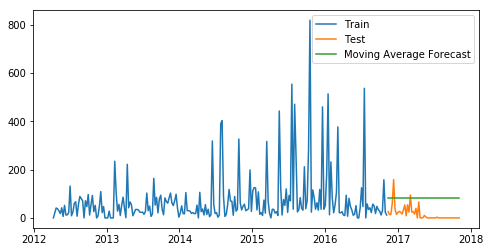

70.59469489094461

In [18]:
# baseline: Moving Average with 52
y_hat['moving_avg'] = moving_average(train_df['9920-2'], m=52)

plot_time_series(train_df, test_df, '9920-2', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'9920-2', y_hat, 'moving_avg')

Okay, 70.59, that's not great. Let's see what Prophet can do:

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


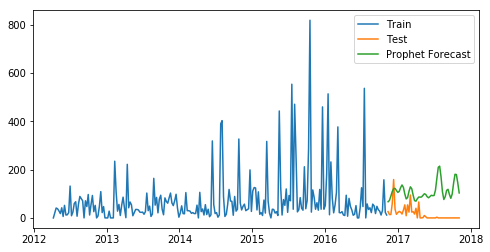

104.04466571337738

In [11]:
# FB Prophet
# make a copy of the dataframe for Prophet transformations
prophet_df = make_copy_df(train_df, '9920-2')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
rename_columns(prophet_df, '9920-2')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)

# fit
my_model.fit(prophet_df)

# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)

# plot
forecast_slice = create_fb_forecast(forecast, 240, 292)
plot_time_series(train_df, test_df, '9920-2', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '9920-2', forecast_slice, 'yhat')

104.04 is 50 percent higher than a simple averaging method! How about Holt-Winters?

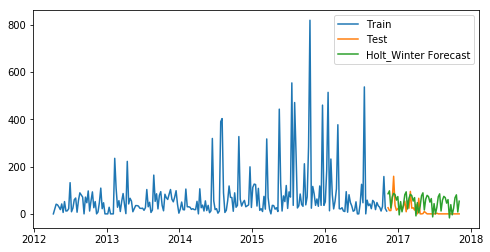

51.35384040458961

In [13]:
# Holt-Winters with additive trend and seasonality, no trend damping, seasonal periods=12
fit1 = ExponentialSmoothing(np.asarray(train_df['9920-2']), 
                            seasonal_periods=12, trend='additive', 
                            seasonal='additive').fit(smoothing_level=0.51,
                            smoothing_slope=0.015, smoothing_seasonal=0.1)

y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '9920-2', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'9920-2', y_hat, 'Holt_Winter')

At 51.35, Holt-Winters does much better (and this is only with some manual tuning based on very simple guidelines).<br>

Given that:
* the accuracy of forecasts is highly dependent on the underlying distribution of data,
* 2 of the 3 forecasting methods require a great deal of parameter tuning, and
* there are 1,833 products to forecast altogether, <br>
it would be best to group together products that move similarly in time and can be forecasted using the same methods.

That's what k-means clustering with dynamic time warping can accomplish. However, before doing that, let's see if some of the products could be eliminated, reducing the 1,833 products to a more reasonable number.

## 4. Segment Products

In [ ]:
# make a list of products
product_SKUs = train_df.columns.values

First I dropped products that are no longer active (defined as products that have not moved after a specified date).

In [55]:
# not active
non_active = identify_non_active(train_df, product_SKUs, 2015, 11, 4)

Then I dropped products that are new, which do not have any history to forecast.

In [56]:
# new products 
new_products = identify_new_product(train_df, product_SKUs, 2015, 11, 4)

Altogether, non active and new products accounted for 610 products. Next, I looked for products with intermittent demand (they should be forecasted using Croston's Method). Intermittent demand was defined as no demand in certain amount of weeks (here, I picked 4).

In [57]:
# intermittent demand    
intermittent_demand = identify_intermittent_product(train_df, product_SKUs, non_active, 2015, 11, 4, 4)

Interestingly, there were no products with intermittent demand. There were some products that are ordered in such small quantities, that spending a great deal of time on manually tuning their forecasting models may not be the best use of time. I set aside items that do not sell more than 30 units.

In [58]:
# products with very little demand
minute_demand = identify_minute_demand(train_df, product_SKUs, 30)

Finally, some products are ordered in large quantities (over 3,000 units) and then repackaged into sets.

In [59]:
# repackaged products
repackage_product = identify_repackage_product(train_df, product_SKUs, 3000)

After dropping the above categories, I was left with 878 products, all ready for clustering with dynamic time warping!

In [60]:
# create leftover dataset for dynamic time warping
products = make_remainder_dataframe(train_df, product_SKUs, non_active, new_products, minute_demand, repackage_product)

## 5. Cluster Products

To cluster together similar time series, I used k-means clustering with dynamic time warping. Dynamic time warping is a measure that finds the best alignment between two time series -- it shows which series move similarly in time. (For more on the method, see Alex Minnaar's excellent blog post: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html)

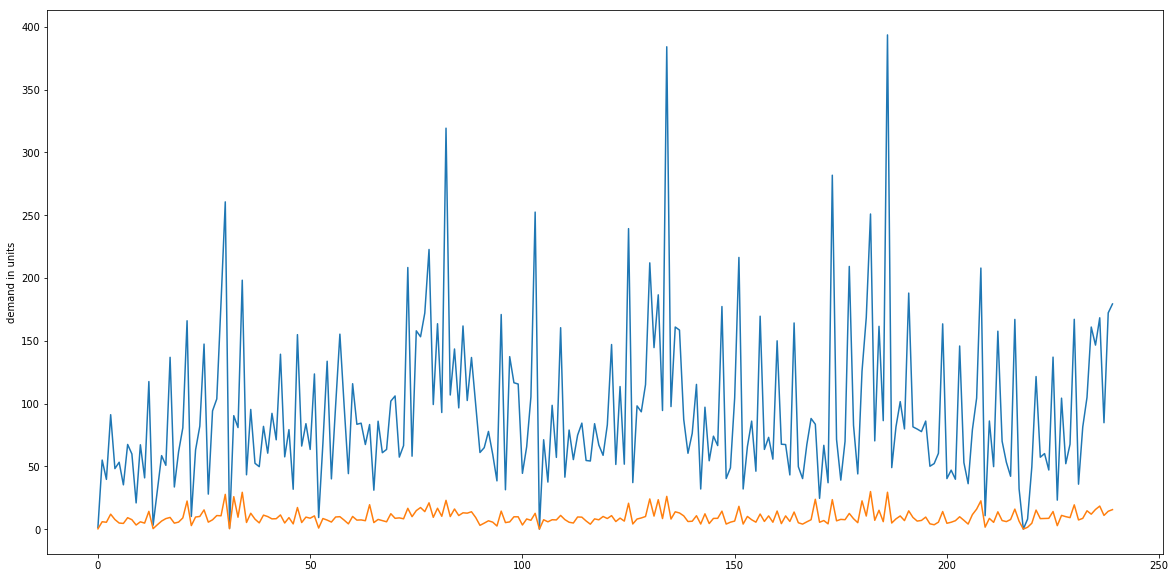

In [62]:
# prepare products df for timewarping
data_arr = prep_dataframe_for_warping(products)

# k-means clustering with k=2
cl_obj=ts_cluster(2)
cl_obj.k_means_clust(data_arr,10,4, progress=False)

# plot the two product types
cl_obj.plot_centroids()

The resulting plot shows two distinct time series types: one with modest fluctations and one with dramatic changes in demand.

In [ ]:
# pickle this model
joblib.dump(cl_obj, "my_model_k2.pkl")

## 6. Evaluate Clusters

Now I have 6 groups of products: not active, new products, minute demand, products for repackaging, and the two clusters (modest fluctuations and seasonal swings). To make sure these groups are truly insightful, I compared the above segmentation method (manual segmentation combined with clustering) to clustering only.

The combination method produces 6 segments and a Calinski-Harabasz index of 114.91. (This index shows how different clusters are from one another. The bigger the number, the sharper the differences between segments.)

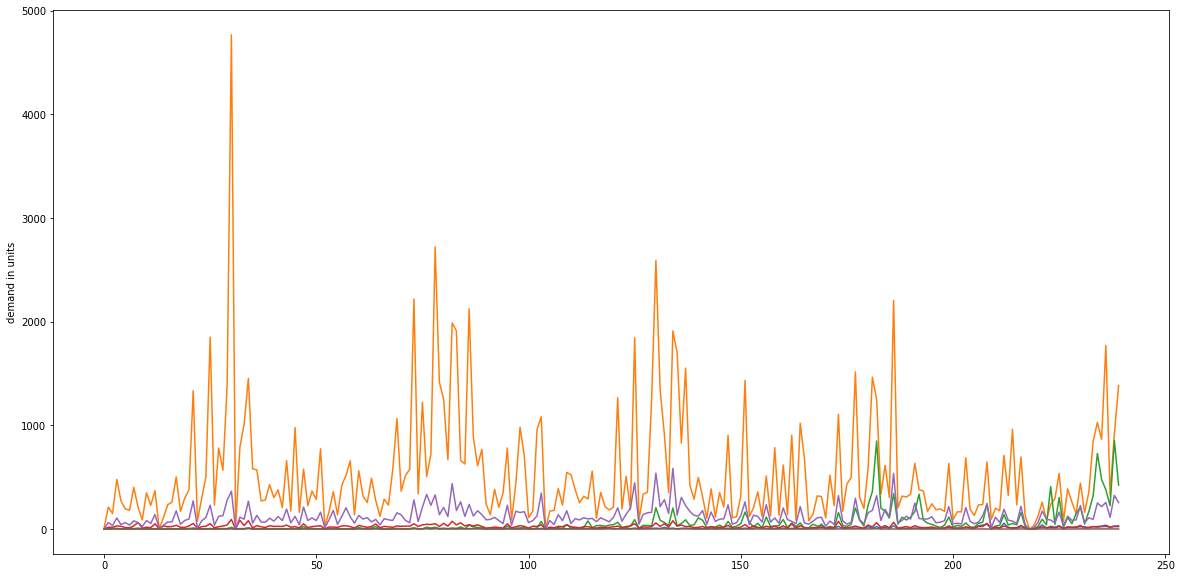

In [24]:
# clustering only

# prepare products df for timewarping
data_arr = prep_dataframe_for_warping(train_df)

# k-means clustering on full dataset with k=6
cl_obj=ts_cluster(6)
cl_obj.k_means_clust(data_arr,10,4, progress=False)

# plot the six product types
cl_obj.plot_centroids()

In [ ]:
products=train_df

# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

# assign products to clusters
product_type0 = assign_products(products.T, assigned_data, 0)
product_type1 = assign_products(products.T, assigned_data, 1)
product_type2 = assign_products(products.T, assigned_data, 2)
product_type3 = assign_products(products.T, assigned_data, 3)
product_type4 = assign_products(products.T, assigned_data, 4)
product_type5 = assign_products(products.T, assigned_data, 5)

# Make a data frame of products
type0_df = make_product_dataframe(products, product_type0, 'type 0')
type1_df = make_product_dataframe(products, product_type1, 'type 1')
type2_df = make_product_dataframe(products, product_type2, 'type 2')
type3_df = make_product_dataframe(products, product_type3, 'type 3')
type4_df = make_product_dataframe(products, product_type4, 'type 4')
type5_df = make_product_dataframe(products, product_type5, 'type 5')

df_new = pd.concat([type0_df, type1_df, type2_df, type3_df, type4_df, type5_df])

In [22]:
# get Caliniski-Harabasz score
X = df_new.iloc[:, df_new.columns != 'label']
y = df_new.label

CH_score_ns_k6 = calinski_harabaz_score(X, y)
CH_score_ns_k6

181.6782369681932

By contrast, creating 6 segments using clustering produces a much higher Calinski-Harabasz index of 181.67. (In other words, the k-means algorithm finds more meaningful patterns in the data than manual segmentation.) Neverthless, teh company may prefer manually splitting out some product groups based on business considerations.

In [23]:
# pickle this model
joblib.dump(cl_obj, "my_model_ns_k6.pkl")

['my_model_ns_k6.pkl']

Now let's look at two products representing two separate product clusters. Decomposing the timeseries into trend, seasonality, and residual errors, it is clear that the clustering picked up distinct patterns.

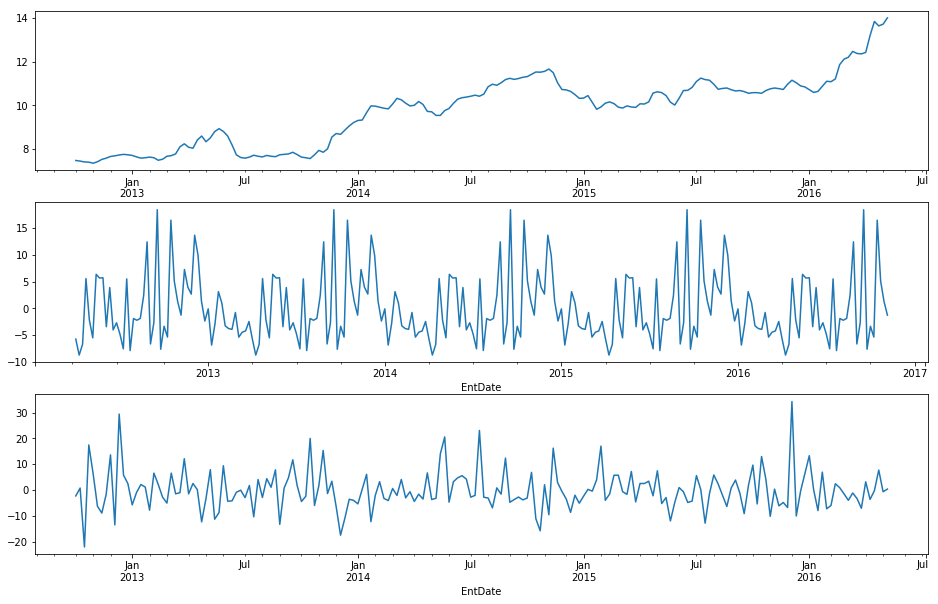

In [4]:
# look at the trend and season components of the timeseries from an item from Product Group 0
decompose_timeseries(train_df['8620'], 'additive')

In [5]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def evaluate_stationarity(timeseries, t=30):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

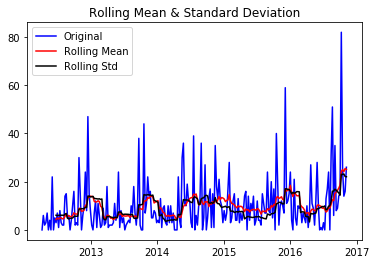

Results of Dickey-Fuller Test:
Test Statistic                  -3.489392
p-value                          0.008264
#Lags Used                       6.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


In [6]:
# is it stationary? No, close
evaluate_stationarity(train_df['8620'], 12)

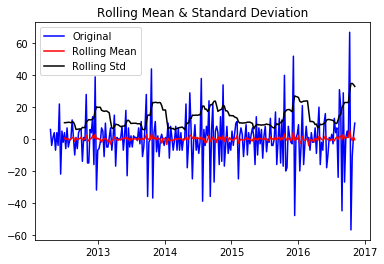

Results of Dickey-Fuller Test:
Test Statistic                -9.961566e+00
p-value                        2.366056e-17
#Lags Used                     6.000000e+00
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


In [9]:
# remove trend
train_df_diff = train_df['8620'].diff()[1:]
# now see stationarity
evaluate_stationarity(train_df_diff, 12)

In [ ]:
# just required one differencing to remove trend -- it should be ready for ARIMA gridsearch

In [31]:
# make a df to store all our predictions
y_hat = make_copy_df(test_df, '8620')

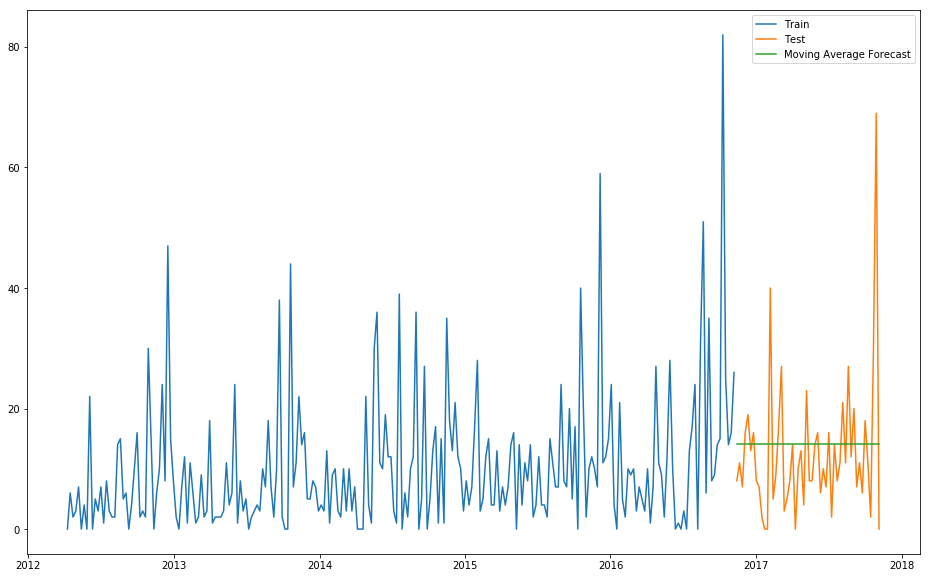

11.434790678880942

In [32]:
# baseline: Moving Average with 52
y_hat['moving_avg'] = moving_average(train_df['8620'], m=52)

plot_time_series(train_df, test_df, '8620', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'8620', y_hat, 'moving_avg')

In [27]:
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0)).fit(y=train_df['8620'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['8620'], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=False, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=1978.640, BIC=1985.593, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1919.467, BIC=1929.896, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1827.081, BIC=1837.511, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 1); AIC=1828.885, BIC=1842.791, Fit time=0.072 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=1829.846, BIC=1847.228, Fit time=0.185 seconds
Total fit time: 0.340 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -910.541
Method:                       css-mle   S.D. of innovations             10.798
Date:                Wed, 06 Jun 2018   AIC                           1827.081
Time:                        14:30:52   BIC                           1837.511
Sample:                             1   HQIC                          1831.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0376      0.010      3.742      0.000       0.018       0.057
ma.L1.D.y     -1.0000      0.014    -71.845      0.000      -1.027      -0.973
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

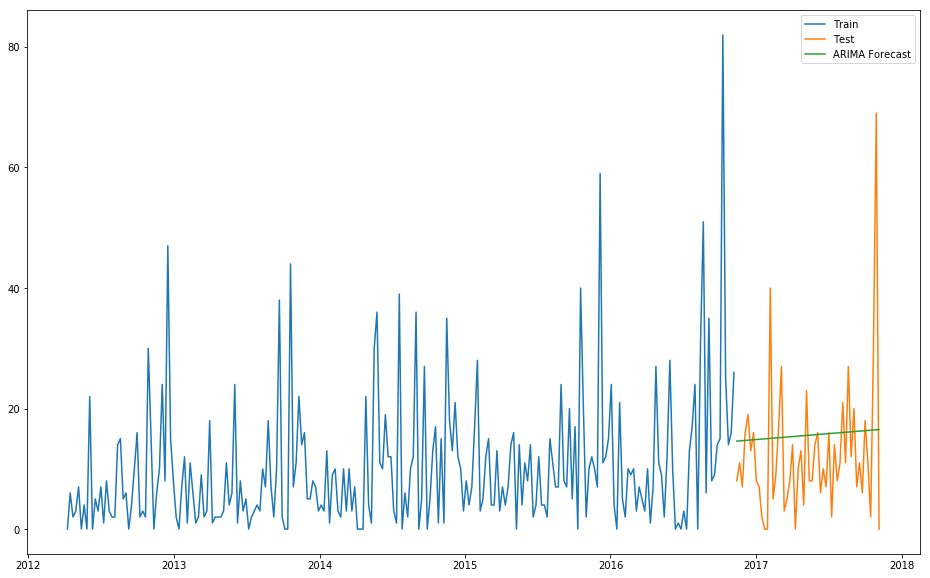

11.621822794515364

In [33]:
from statsmodels.tsa.arima_model import ARIMA


fit = ARIMA(train_df['8620'], order=(0,1,1), freq='W').fit()
y_hat['ARIMA'] = fit.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')
#fit1 = SARIMAX(train_df['9740-1'], order=(2, 1, 2), seasonal_order=(2,1,0,52), freq='W').fit()
#y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '8620', y_hat, 'ARIMA', 'ARIMA Forecast')

# calculate RMSE
RMSE(test_df,'8620', y_hat, 'ARIMA')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


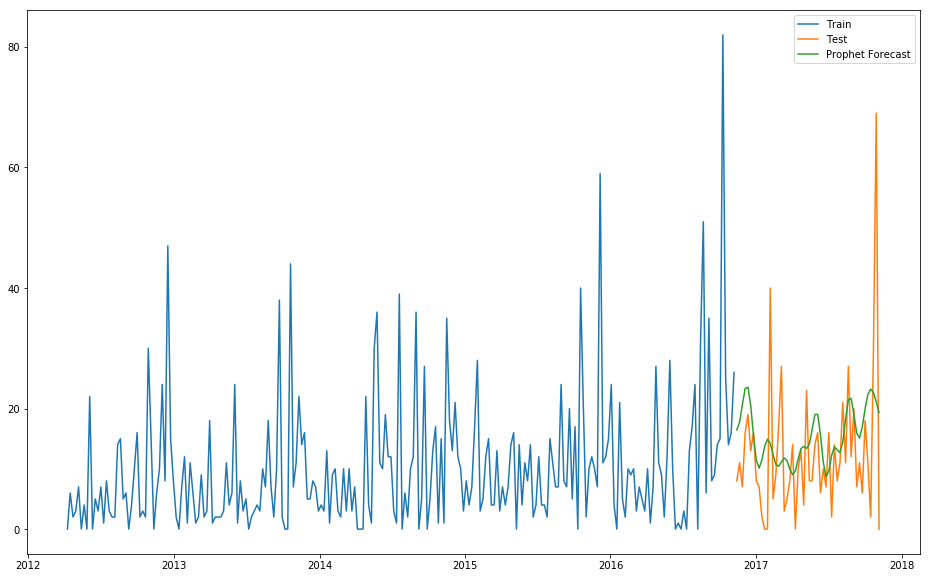

11.228112082249519

In [34]:
# FB Prophet
# make a copy of the dataframe for Prophet transformations
prophet_df = make_copy_df(train_df, '8620')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
rename_columns(prophet_df, '8620')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)

# fit
my_model.fit(prophet_df)

# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)

# plot
forecast_slice = create_fb_forecast(forecast, 240, 292)
plot_time_series(train_df, test_df, '8620', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '8620', forecast_slice, 'yhat')

Both products have trends and seasonal patterns. However, there are clear differences.

The first product type only has a mild seasonal pattern, while the second product has strong seasonal fluctuations in demand. Further, the unexplained residuals on the second product group span on a scale of over 3,000 units (compared to merely 50 units on the first group).

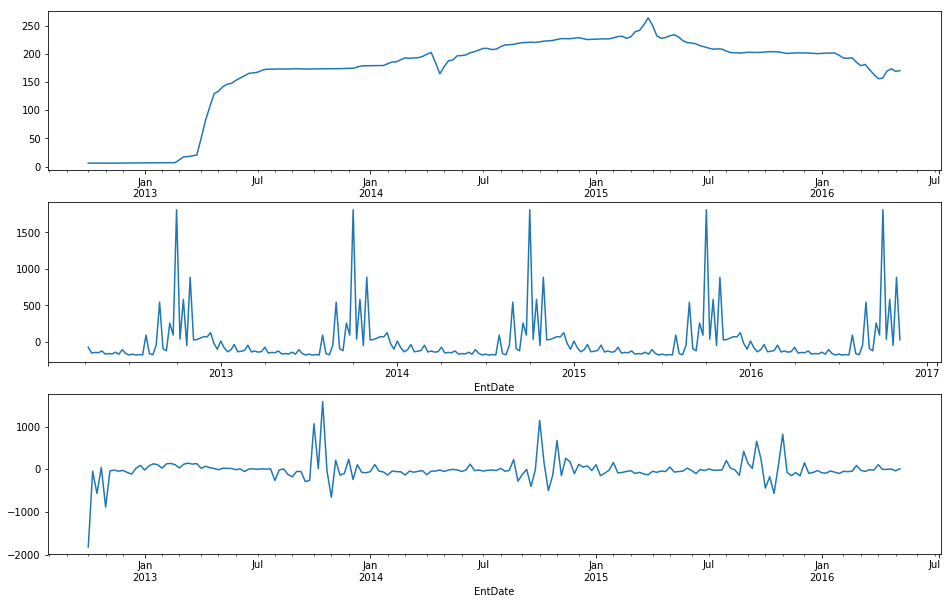

In [19]:
# look at the trend and season components of the timeseries from an item from Product Group 4
decompose_timeseries(train_df['9740-1'], 'additive')

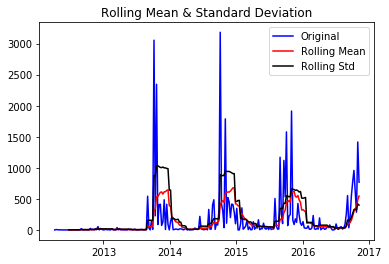

Results of Dickey-Fuller Test:
Test Statistic                  -3.220317
p-value                          0.018838
#Lags Used                       4.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [14]:
# is it stationary? of course not - not even close
evaluate_stationarity(train_df['9740-1'], 12)

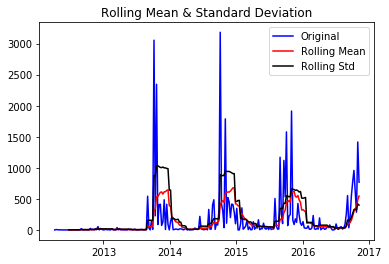

Results of Dickey-Fuller Test:
Test Statistic                  -3.220317
p-value                          0.018838
#Lags Used                       4.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [15]:
# remove trend
train_df_diff2 = train_df['9740-1'].diff()[1:]
# then see stationarity
evaluate_stationarity(train_df['9740-1'], 12)

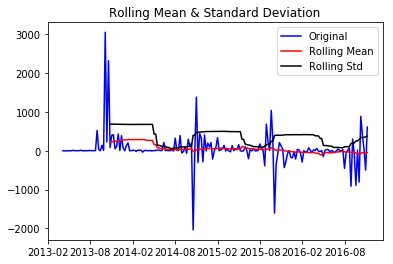

Results of Dickey-Fuller Test:
Test Statistic                -8.284244e+00
p-value                        4.434730e-13
#Lags Used                     1.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


In [18]:
# better but not ready
# remove seasonality
train_df_diff2['seasonal_difference'] = train_df['9740-1'] - train_df['9740-1'].shift(52)
# then see stationarity
evaluate_stationarity(train_df_diff2['seasonal_difference'].dropna(inplace=False))

In [ ]:
# now it's ready for seasonal ARIMA gridsearch

In [21]:
# make a df to store all our predictions
y_hat = make_copy_df(test_df, '9740-1')

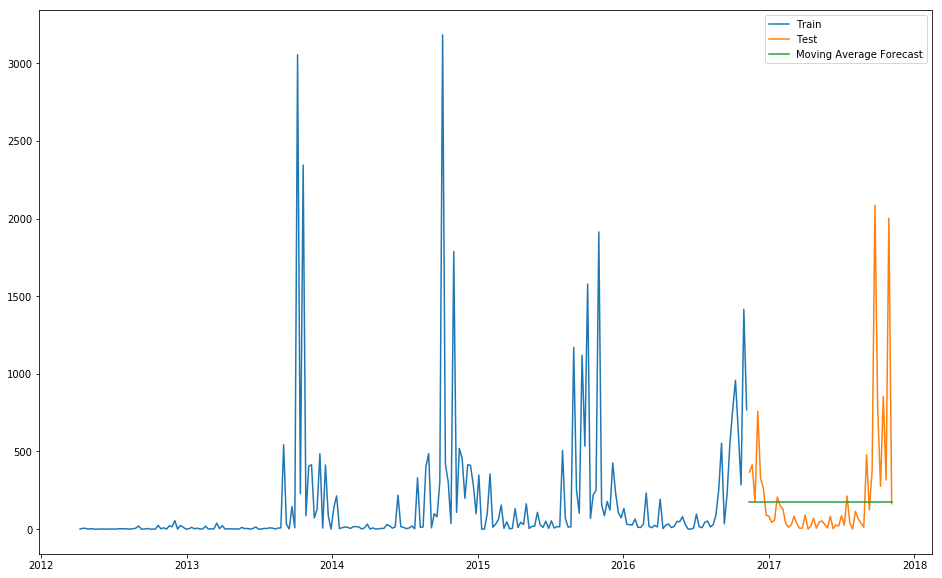

417.2259885454782

In [22]:
# baseline: Moving Average with 52
y_hat['moving_avg'] = moving_average(train_df['9740-1'], m=52)

plot_time_series(train_df, test_df, '9740-1', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'9740-1', y_hat, 'moving_avg')

In [24]:
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['9740-1'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['9740-1'], start_p=0, start_q=0, max_p=6, max_q=6, m=52,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=2918.206, BIC=2924.668, Fit time=0.442 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=2841.376, BIC=2854.300, Fit time=5.168 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=2847.876, BIC=2857.569, Fit time=0.317 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=2806.788, BIC=2822.944, Fit time=24.556 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=2898.696, BIC=2911.620, Fit time=16.044 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=2786.356, BIC=2805.742, Fit time=32.452 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 52); AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(2, 1, 2)x(2, 1, 0, 52)   Log Likelihood               -1371.642
Date:                            Wed, 06 Jun 2018   AIC                           2759.284
Time:                                    13:57:48   BIC                           2785.133
Sample:                                         0   HQIC                          2769.758
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6514      0.784     -0.831      0.406      -2.187       0.884
ar.L1          0.4552      0.245      1.859      0.063      -0.025       0.935
ar.L2          0.2571      0.059      4.332      0.000       0.141       0.373
ma.L1         -1.5656      0.246     -6.364      0.000      -2.048      -1.083
ma.L2          0.5657      0.239      2.362      0.018       0.096       1.035
ar.S.L52      -0.3467      0.035     -9.856      0.000      -0.416      -0.278
ar.S.L104     -0.5410      0.058     -9.280      0.000      -0.655      -0.427
sigma2      1.117e+05   3.35e-06   3.33e+10      0.000    1.12e+05    1.12e+05
===================================================================================
Ljung-Box (Q):                        7.74   Jarque-Bera (JB):              2970.35
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.36
Prob(H) (two-sided):                  0.15   Kurtosis:                        21.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.84e+27. Standard errors may be unstable.
"""

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


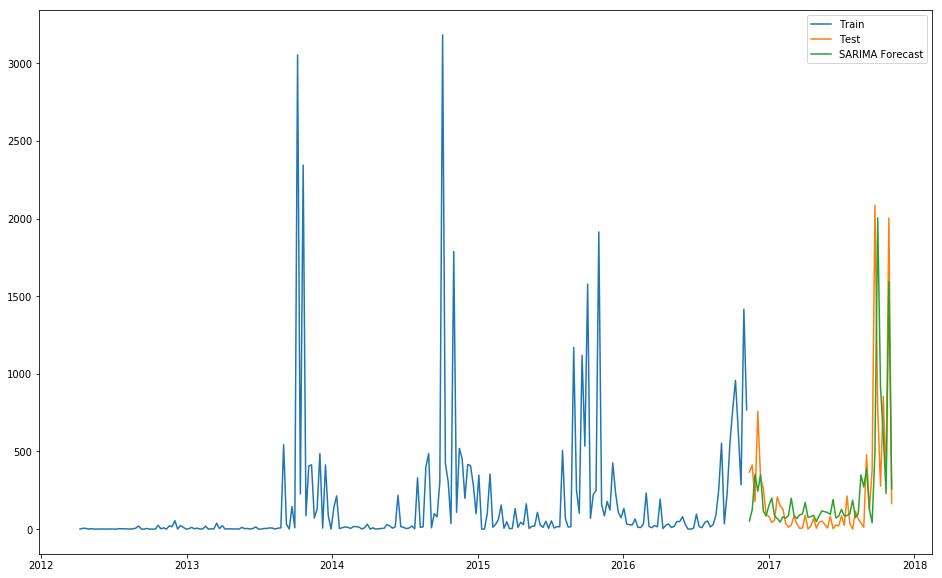

332.8182772218235

In [25]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['9740-1'], order=(2, 1, 2), seasonal_order=(2,1,0,52), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '9740-1', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE
RMSE(test_df,'9740-1', y_hat, 'SARIMA')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


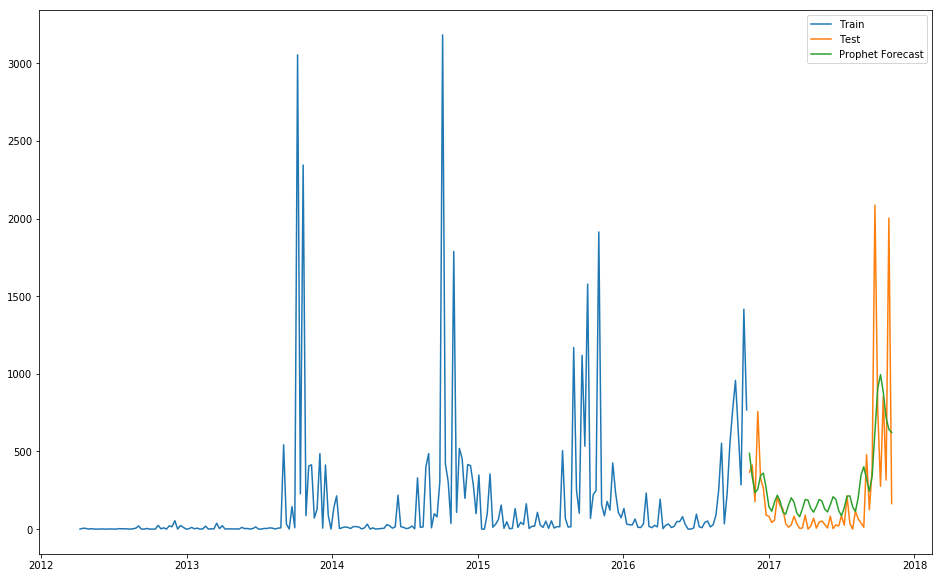

337.1077480957434

In [26]:
# FB Prophet
# make a copy of the dataframe for Prophet transformations
prophet_df = make_copy_df(train_df, '9740-1')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
rename_columns(prophet_df, '9740-1')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)

# fit
my_model.fit(prophet_df)

# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)

# plot
forecast_slice = create_fb_forecast(forecast, 240, 292)
plot_time_series(train_df, test_df, '9740-1', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '9740-1', forecast_slice, 'yhat')

## 7. Next Steps

K-means clustering with dynamic time warping as a distance measure is a great tool for finding patterns in time series data.
Next steps for this project are:
* Picking the segmentation method and parameters to use. The company needs to determine whether some product groups and orders should be flagged for special treatment based on business considerations. 
* Clustering the data so that it can be passed to various forecasting models. since there is no standard statistical method to find the "best" number of clusters for k-means clustering, the company needs to specify how many clusters they would prefer to see. 
* Devising hypothesis test to match product groups with forecasting models, considering trends, seasonality, and smoothing parameters.

## Resources:

### 2. Train-Test Split: 
For more on time series data and cross-validation, see 
[this blog post] (https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
this blog post: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

### 3. Forecasting Models:
* Time Series (ETS) tutorial: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
* More on exponential smoothing: https://www.otexts.org/fpp/7 and https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
* Time Series (ARMA) overview: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels
* ARIMA tutorial: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
* ARIMA with pyramid library: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

### 5. Clustering with Dynamic Time Warping:
* Excellent blog post (with link to code in GitHub): http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
* Several resources in comments below: https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa